In [16]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import Callback
import numpy as np
from matplotlib import pyplot as plt
import math
import cv2
import random
import os
from shutil import copyfile

root = '../IDAO/track-1/'

# Pre-processing
We implement the following pre-processing steps for our model
- ****Oversampling:****: We oversample the 'test' classes to compensate for fewer number of samples
- ****Denoising:****: We denoise all images to reduce camera noise
- ****Center-cropping****: We center-crop all images to focus on only the relevant part of the image
- ****Random rotation****: We randomly rotate the training images to make our model rotation invariant

In [17]:
er_train_folder = root+'train/ER/'
nr_train_folder = root+'train/NR/'

public_test_folder = root+'public_test/'
private_test_folder = root+'private_test/'

train_folder = root+'all_train/'
test_folder = root+'all_test/'

denoised_train_folder = root+'all_train_denoised/'
denoised_test_folder = root+'all_test_denoised/'

In [ ]:
#merge all train images into a single folder named 'all_train'

for filename in os.listdir(er_train_folder):
    copyfile(er_train_folder+filename, train_folder+filename)
for filename in os.listdir(nr_train_folder):
    copyfile(nr_train_folder+filename, train_folder+filename)

In [ ]:
#merge all test images into a single folder named 'all_test'

for filename in os.listdir(public_test_folder):
    copyfile(public_test_folder+filename, test_folder+filename)
for filename in os.listdir(private_test_folder):
    copyfile(private_test_folder+filename, test_folder+filename)

In [18]:
#create dataframe for training data
ids = []
classes = []
energies = []

for filename in os.listdir(train_folder):
    
    if not filename.endswith('.png'):
        continue
    
    ids.append(filename)
    
    i = 6
    
    if filename.split('_')[5] != 'He':
        i -= 1
    
    cls = filename.split('_')[i]
    classes.append(cls)
    
    energy = filename.split('_')[i+1]
    energies.append((float)(energy))

df = pd.DataFrame({
    'id': ids,
    'class': classes,
    'energy': energies
})

df

,id,class,energy
0,-0.0026000000070780516__CYGNO_60_40_He_NR_6_ke...,NR,6.0
1,-0.003018522635102272__CYGNO_60_40_ER_30_keV_9...,ER,30.0
2,-0.0031084376387298107__CYGNO_60_40_ER_3_keV_9...,ER,3.0
3,-0.003241758095100522__CYGNO_60_40_ER_3_keV_93...,ER,3.0
4,-0.0032767392694950104__CYGNO_60_40_ER_10_keV_...,ER,10.0
...,...,...,...
13276,3.1387999057769775__CYGNO_60_40_He_NR_1_keV_93...,NR,1.0
13277,3.140399932861328__CYGNO_60_40_He_NR_20_keV_93...,NR,20.0
13278,3.1407999992370605__CYGNO_60_40_He_NR_20_keV_9...,NR,20.0
13279,3.1412999629974365__CYGNO_60_40_He_NR_6_keV_93...,NR,6.0


In [19]:
#test classes have only a handful of samples in our dataset

df_er_1 = df.loc[(df['class']=='ER') & (df['energy']==1)]
df_er_3 = df.loc[(df['class']=='ER') & (df['energy']==3)]
df_er_6 = df.loc[(df['class']=='ER') & (df['energy']==6)]
df_er_10 = df.loc[(df['class']=='ER') & (df['energy']==10)]
df_er_20 = df.loc[(df['class']=='ER') & (df['energy']==20)]
df_er_30 = df.loc[(df['class']=='ER') & (df['energy']==30)]
df_nr_1 = df.loc[(df['class']=='NR') & (df['energy']==1)]
df_nr_3 = df.loc[(df['class']=='NR') & (df['energy']==3)]
df_nr_6 = df.loc[(df['class']=='NR') & (df['energy']==6)]
df_nr_10 = df.loc[(df['class']=='NR') & (df['energy']==10)]
df_nr_20 = df.loc[(df['class']=='NR') & (df['energy']==20)]
df_nr_30 = df.loc[(df['class']=='NR') & (df['energy']==30)]

print('ER\n======')
print(len(df_er_1))
print(len(df_er_3))
print(len(df_er_6))
print(len(df_er_10))
print(len(df_er_20))
print(len(df_er_30))
print('NR\n======')
print(len(df_nr_1))
print(len(df_nr_3))
print(len(df_nr_6))
print(len(df_nr_10))
print(len(df_nr_20))
print(len(df_nr_30))

ER
3
2243
1
2272
2
2237
NR
2171
2
2245
2
2101
2


In [20]:
#test classes are oversampled to prevent the model from ignoring them

df_er_1 = pd.concat([df_er_1]*765, ignore_index=True)
df_nr_3 = pd.concat([df_nr_3]*1121, ignore_index=True)
df_er_6 = pd.concat([df_er_6]*2255, ignore_index=True)
df_nr_10 = pd.concat([df_nr_10]*1136, ignore_index=True)
df_er_20 = pd.concat([df_er_20]*1104, ignore_index=True)
df_nr_30 = pd.concat([df_nr_30]*1118, ignore_index=True)

print('ER\n======')
print(len(df_er_1))
print(len(df_er_3))
print(len(df_er_6))
print(len(df_er_10))
print(len(df_er_20))
print(len(df_er_30))
print('NR\n======')
print(len(df_nr_1))
print(len(df_nr_3))
print(len(df_nr_6))
print(len(df_nr_10))
print(len(df_nr_20))
print(len(df_nr_30))

ER
2295
2243
2255
2272
2208
2237
NR
2171
2242
2245
2272
2101
2236


In [22]:
#We split the data for training and validation

df_er_1 = df_er_1.sample(frac=1)
df_er_3 = df_er_3.sample(frac=1)
df_er_6 = df_er_6.sample(frac=1)
df_er_10 = df_er_10.sample(frac=1)
df_er_20 = df_er_20.sample(frac=1)
df_er_30 = df_er_30.sample(frac=1)
df_nr_1 = df_nr_1.sample(frac=1)
df_nr_3 = df_nr_3.sample(frac=1)
df_nr_6 = df_nr_6.sample(frac=1)
df_nr_10 = df_nr_10.sample(frac=1)
df_nr_20 = df_nr_20.sample(frac=1)
df_nr_30 = df_nr_30.sample(frac=1)

def split(df, ratio):
    index = round(len(df)*ratio)
    return df[:index], df[index:]

ratio = .8

df_er_1_train, df_er_1_val = split(df_er_1, ratio)
df_er_3_train, df_er_3_val = split(df_er_3, ratio)
df_er_6_train, df_er_6_val = split(df_er_6, ratio)
df_er_10_train, df_er_10_val = split(df_er_10, ratio)
df_er_20_train, df_er_20_val = split(df_er_20, ratio)
df_er_30_train, df_er_30_val = split(df_er_30, ratio)
df_nr_1_train, df_nr_1_val = split(df_nr_1, ratio)
df_nr_3_train, df_nr_3_val = split(df_nr_3, ratio)
df_nr_6_train, df_nr_6_val = split(df_nr_6, ratio)
df_nr_10_train, df_nr_10_val = split(df_nr_10, ratio)
df_nr_20_train, df_nr_20_val = split(df_nr_20, ratio)
df_nr_30_train, df_nr_30_val = split(df_nr_30, ratio)

print('ER\n======')
print('Train:',len(df_er_1_train),'Val:',len(df_er_1_val))
print('Train:',len(df_er_3_train),'Val:',len(df_er_3_val))
print('Train:',len(df_er_6_train),'Val:',len(df_er_6_val))
print('Train:',len(df_er_10_train),'Val:',len(df_er_10_val))
print('Train:',len(df_er_20_train),'Val:',len(df_er_20_val))
print('Train:',len(df_er_30_train),'Val:',len(df_er_30_val))
print('NR\n======')
print('Train:',len(df_nr_1_train),'Val:',len(df_nr_1_val))
print('Train:',len(df_nr_3_train),'Val:',len(df_nr_3_val))
print('Train:',len(df_nr_6_train),'Val:',len(df_nr_6_val))
print('Train:',len(df_nr_10_train),'Val:',len(df_nr_10_val))
print('Train:',len(df_nr_20_train),'Val:',len(df_nr_20_val))
print('Train:',len(df_nr_30_train),'Val:',len(df_nr_30_val))

ER
Train: 1836 Val: 459
Train: 1794 Val: 449
Train: 1804 Val: 451
Train: 1818 Val: 454
Train: 1766 Val: 442
Train: 1790 Val: 447
NR
Train: 1737 Val: 434
Train: 1794 Val: 448
Train: 1796 Val: 449
Train: 1818 Val: 454
Train: 1681 Val: 420
Train: 1789 Val: 447


In [23]:
df_er_train = pd.concat([
    df_er_1_train,
    df_er_3_train,
    df_er_6_train,
    df_er_10_train,
    df_er_20_train,
    df_er_30_train
])

df_nr_train = pd.concat([
    df_nr_1_train,
    df_nr_3_train,
    df_nr_6_train,
    df_nr_10_train,
    df_nr_20_train,
    df_nr_30_train
])

train_data = pd.concat([df_er_train, df_nr_train])
train_data = train_data.sample(frac=1)

train_data

,id,class,energy
528,0.48575398325920105__CYGNO_60_40_ER_1_keV_930V...,ER,1.0
1877,0.9950000047683716__CYGNO_60_40_He_NR_30_keV_9...,NR,30.0
1036,-0.48257502913475037__CYGNO_60_40_ER_20_keV_93...,ER,20.0
1129,0.5620372891426086__CYGNO_60_40_ER_20_keV_930V...,ER,20.0
512,-0.9444000124931335__CYGNO_60_40_He_NR_10_keV_...,NR,10.0
...,...,...,...
1765,0.5620372891426086__CYGNO_60_40_ER_20_keV_930V...,ER,20.0
1733,0.5620372891426086__CYGNO_60_40_ER_20_keV_930V...,ER,20.0
10833,1.325623631477356__CYGNO_60_40_ER_3_keV_930V_3...,ER,3.0
646,-0.48257502913475037__CYGNO_60_40_ER_20_keV_93...,ER,20.0


In [25]:
df_er_val = pd.concat([
    df_er_1_val,
    df_er_3_val,
    df_er_6_val,
    df_er_10_val,
    df_er_20_val,
    df_er_30_val
])

df_nr_val = pd.concat([
    df_nr_1_val,
    df_nr_3_val,
    df_nr_6_val,
    df_nr_10_val,
    df_nr_20_val,
    df_nr_30_val
])

val_data = pd.concat([df_er_val, df_nr_val])
val_data = val_data.sample(frac=1)

val_data

,id,class,energy
9460,0.8904429078102112__CYGNO_60_40_ER_3_keV_930V_...,ER,3.0
940,-0.9444000124931335__CYGNO_60_40_He_NR_10_keV_...,NR,10.0
12429,2.3698999881744385__CYGNO_60_40_He_NR_1_keV_93...,NR,1.0
1083,1.419700026512146__CYGNO_60_40_He_NR_3_keV_930...,NR,3.0
9656,0.9485015273094177__CYGNO_60_40_ER_10_keV_930V...,ER,10.0
...,...,...,...
10015,1.055946707725525__CYGNO_60_40_ER_3_keV_930V_3...,ER,3.0
1234,1.195670247077942__CYGNO_60_40_ER_6_keV_930V_3...,ER,6.0
887,2.21054744720459__CYGNO_60_40_ER_1_keV_930V_30...,ER,1.0
275,0.5620372891426086__CYGNO_60_40_ER_20_keV_930V...,ER,20.0


In [26]:
#utility functions and variables

img_height = 576
img_width = 576

target_height = 144
target_width = 144

def center_crop(img):
    h = img.shape[0]
    w = img.shape[1]
    left = (int)(w/4)
    top = (int)(h/4)
    right = left + (int)(w/2)
    bottom =top + (int)(h/2)

    img = img[top:bottom, left:right,]
    return img

def denoise(img):
    return cv2.fastNlMeansDenoising(img,None,10,7,21)

def random_rotate(img):
    img = image.random_rotation(
        img, 360, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest',
        cval=0.0, interpolation_order=1
        )
    return img

def load_image(path, rotate=True):
    img = image.load_img(path, target_size = (img_height, img_width), color_mode='grayscale')
    img = image.img_to_array(img)
    img = center_crop(center_crop(img))
    if rotate:
        img = random_rotate(img)
    img = img/255.0
    return img

In [ ]:
#denoise all train images and put them into 'all_train_denoised' folder'

src_folder = train_folder
dst_folder = denoised_train_folder

filenames = os.listdir(src_folder)
for i in range(len(filenames)):
    
    print('processed',i+1,'images',end='\r')
    
    filename = filenames[i]
    
    if not filename.endswith('.png'):
        continue

    img = cv2.imread(src_folder+filename,0)
    img = denoise(img)
    cv2.imwrite(dst_folder+filename, img)

In [ ]:
#denoise all test images and put them into 'all_test_denoised' folder'

src_folder = test_folder
dst_folder = denoised_test_folder

filenames = os.listdir(src_folder)
for i in range(len(filenames)):
    
    print('processed',i+1,'images',end='\r')
    
    filename = filenames[i]
    
    if not filename.endswith('.png'):
        continue

    img = cv2.imread(src_folder+filename,0)
    img = denoise(img)
    cv2.imwrite(dst_folder+filename, img)

In [27]:
class datagen(Sequence):
    
    def __init__(self, dataframe, batch_size):
        
        self.dataframe = dataframe
        self.batch_size = batch_size
        
    def __len__(self):
        return math.ceil(len(self.dataframe) / self.batch_size)
        
    def __getitem__(self, ind):
        
        #print('Starting batch',ind)
        
        partial_dataframe = self.dataframe[ind * self.batch_size : (ind + 1) * self.batch_size]
        
        imgs = list(partial_dataframe['id'])
        x = self.get_img(imgs)
        
        classes = list(partial_dataframe['class'])
        energies = list(partial_dataframe['energy'])
        
        y1 = self.get_class(classes)
        y2 = self.get_energy(energies)
        
        y = [y1, y2]
        return x, y
        
    def get_img(self, imgs):
        #print('getting image feature')
        
        r = np.ndarray((len(imgs), target_height, target_height, 1), dtype='float32')
        
        for i, img in enumerate(imgs):
            img = load_image(denoised_train_folder+img)
            r[i] = img
            
        return r
    
    def get_class(self, classes):
        
        r = np.ndarray((len(classes)), dtype='float32')
        
        for i, cls in enumerate(classes):
            if(cls=='NR'):
                r[i] = 0
            else:
                r[i] = 1
        return r
    
    def get_energy(self, energies):
        
        r = np.ndarray((len(energies)), dtype='float32')
        
        for i, energy in enumerate(energies):
            r[i] = energy
        return r

In [32]:
batch_size = 32

train_datagen = datagen(train_data, batch_size=batch_size)
val_datagen = datagen(val_data, batch_size=batch_size)

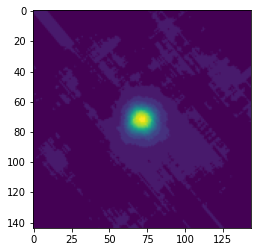

0.0
10.0


In [30]:
for x in train_datagen:
    
    ind = 22
    
    img = x[0][ind]
    plt.imshow(img)
    plt.show()
    
    cls = x[1][0][ind]
    print(cls)
    
    energy = x[1][1][ind]
    print(energy)
    
    break

In [31]:
inputs = Input(shape=(target_height, target_width, 1))

x = Conv2D(64, (3,3), activation='relu', input_shape=(target_height,target_width,1))(inputs)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', input_shape=(target_height,target_width,1))(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', input_shape=(target_height,target_width,1))(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', input_shape=(target_height,target_width,1))(x)
x = MaxPooling2D(2,2)(x)
'''
x = Conv2D(64, (3,3), activation='relu', input_shape=(target_height,target_width,1))(x)
x = MaxPooling2D(2,2)(x)
'''

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

class_output = Dense(1, activation='sigmoid', name='class')(x)
energy_output = Dense(1, name='energy')(x)

model = Model(inputs=inputs, outputs=[class_output, energy_output])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 144, 144, 1) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 142, 142, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 71, 71, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 69, 69, 64)   36928       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

In [33]:
checkpoint_filepath = root+'weights.hdf5'
#model.load_weights(checkpoint_filepath)

In [34]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(
    loss={
            'class': 'binary_crossentropy', 
            'energy': 'mean_squared_error'
    }, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics = {
            'class': 'accuracy',
            'energy': 'mean_absolute_error'
    }
)

history = model.fit(
    train_datagen,
    epochs = 40,
    validation_data = val_datagen,
    callbacks = [model_checkpoint_callback]
)

Train for 670 steps, validate for 168 steps
Epoch 1/40
670/670 [==============================] - 265s 396ms/step - loss: 72.2340 - class_loss: 0.6834 - energy_loss: 71.5506 - class_accuracy: 0.5362 - energy_mean_absolute_error: 6.5241 - val_loss: 37.1500 - val_class_loss: 0.6356 - val_energy_loss: 36.5144 - val_class_accuracy: 0.5973 - val_energy_mean_absolute_error: 3.7372
Epoch 2/40
670/670 [==============================] - 127s 189ms/step - loss: 15.7253 - class_loss: 0.5577 - energy_loss: 15.1677 - class_accuracy: 0.6198 - energy_mean_absolute_error: 2.5924 - val_loss: 9.7584 - val_class_loss: 0.5354 - val_energy_loss: 9.2230 - val_class_accuracy: 0.7133 - val_energy_mean_absolute_error: 2.1687
Epoch 3/40
670/670 [==============================] - 127s 190ms/step - loss: 8.1353 - class_loss: 0.5138 - energy_loss: 7.6215 - class_accuracy: 0.6737 - energy_mean_absolute_error: 1.8204 - val_loss: 16.9518 - val_class_loss: 0.5309 - val_energy_loss: 16.4209 - val_class_accuracy: 0.6070

Epoch 26/40
670/670 [==============================] - 127s 189ms/step - loss: 1.2710 - class_loss: 0.1413 - energy_loss: 1.1297 - class_accuracy: 0.9480 - energy_mean_absolute_error: 0.6836 - val_loss: 1.2658 - val_class_loss: 0.1454 - val_energy_loss: 1.1204 - val_class_accuracy: 0.9757 - val_energy_mean_absolute_error: 0.6866
Epoch 27/40
670/670 [==============================] - 127s 190ms/step - loss: 1.3226 - class_loss: 0.1500 - energy_loss: 1.1726 - class_accuracy: 0.9442 - energy_mean_absolute_error: 0.6986 - val_loss: 1.4780 - val_class_loss: 0.1409 - val_energy_loss: 1.3371 - val_class_accuracy: 0.9744 - val_energy_mean_absolute_error: 0.6686
Epoch 28/40
670/670 [==============================] - 128s 190ms/step - loss: 1.3994 - class_loss: 0.1532 - energy_loss: 1.2462 - class_accuracy: 0.9421 - energy_mean_absolute_error: 0.7217 - val_loss: 1.2850 - val_class_loss: 0.1277 - val_energy_loss: 1.1573 - val_class_accuracy: 0.9729 - val_energy_mean_absolute_error: 0.6664
Epoch 2

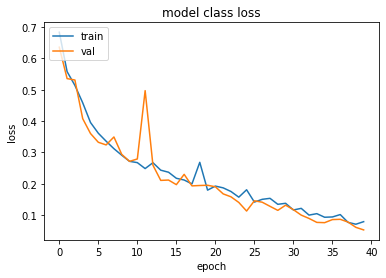

In [35]:
plt.plot(history.history['class_loss'])
plt.plot(history.history['val_class_loss'])
plt.title('model class loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

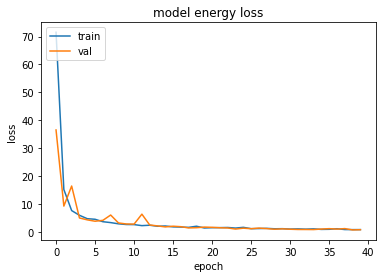

In [36]:
plt.plot(history.history['energy_loss'])
plt.plot(history.history['val_energy_loss'])
plt.title('model energy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

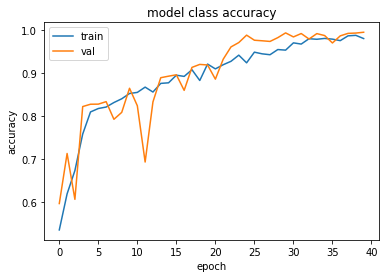

In [37]:
plt.plot(history.history['class_accuracy'])
plt.plot(history.history['val_class_accuracy'])
plt.title('model class accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

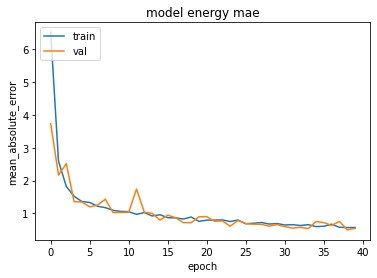

In [38]:
plt.plot(history.history['energy_mean_absolute_error'])
plt.plot(history.history['val_energy_mean_absolute_error'])
plt.title('model energy mae')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
model.load_weights(checkpoint_filepath)

In [40]:
def load_and_predict(path):
    x = load_image(path, rotate=False)
    x = np.expand_dims(x, axis=0)
    x = model.predict(x)
    #x = x[0][0]
    return round(x[0][0][0]), x[1][0][0]

class_counts = [0,0]
energy_counts = [0,0,0,0,0,0]
total_loss = 0.0

#this function returns the energy level(1,3,6,10,20,30) that x is closest to
def closest(x):
    r = 0
    diff = 100
    
    levels = [1,3,6,10,20,30]
    for level in levels:
        if abs(x-level) < diff:
            diff = abs(x-level)
            r = level
    
    energy_counts[levels.index(r)]+=1
    return r

In [46]:
#Creating the csv file containing the predictions

ids = []
class_preds = []
energy_preds = []

for filename in os.listdir(root+'all_test_denoised'):
    path = root+'all_test_denoised/'+filename
    cls, energy = load_and_predict(path)
    
    ids.append(filename[:-4])
    class_preds.append(cls)
    #we round our regression predictions to their nearest energy levels
    #our model seems to have a harder time differentiating between 1kev and 3kev samples
    #so for predictions falling between 1 and 3, we leave them as they are to reduce mean absolute error
    if energy>1 and energy<3:
        energy_preds.append(energy)
    else:
        energy_preds.append(closest(energy))

preds = pd.DataFrame({
            'id': ids,
            'classification_predictions': class_preds,
            'regression_predictions': energy_preds
        })
preds.to_csv(root+'track1_predictions_example.csv', index=False)
preds

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,6.000000
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,20.000000
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0,30.000000
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1.003533
4,000eb12def5371089743dcfe401a8e399f5883fc,0,30.000000
...,...,...,...
16555,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,0,10.000000
16556,ffed718417c6923844d33e70491c54396e3ec1ed,0,1.636903
16557,ffedc12ec5c142dae2086408b778cf0db2ff944e,1,3.000000
16558,fff7b36d8ef90c90d9598620b87dabc0360f501c,0,1.000000


In [43]:
#Predicting Public Test Samples

class_counts = [0,0]
energy_counts = [0,0,0,0,0,0]
total_loss = 0.0

test = os.listdir(root+'public_test')

for filename in os.listdir(root+'all_test_denoised'):
    if filename not in test:
        continue
    
    path = root+'all_test_denoised/'+filename
    cls, energy = load_and_predict(path)
    
    class_counts[cls]+=1
    total_loss+=abs(energy-closest(energy))

print(class_counts)
print(energy_counts)
print(total_loss/sum(energy_counts))

[766, 736]
[249, 255, 247, 251, 252, 248]
0.746498205591137


In [44]:
#Predicting Private Test Samples

class_counts = [0,0]
energy_counts = [0,0,0,0,0,0]
total_loss = 0.0

test = os.listdir(root+'private_test')

for filename in os.listdir(root+'all_test_denoised'):
    if filename not in test:
        continue
    
    path = root+'all_test_denoised/'+filename
    cls, energy = load_and_predict(path)
    
    class_counts[cls]+=1
    total_loss+=abs(energy-closest(energy))

print(class_counts)
print(energy_counts)
print(total_loss/sum(energy_counts))

[8774, 6284]
[2701, 2305, 2509, 2486, 2473, 2584]
1.2097806361709114
